## Softmax

In [1]:
import numpy as np

In [19]:
vector = np.array([11231, 999, 123142])

In [28]:
vector = np.array([-10, 10, 24])

In [33]:
def softmax(vec):
    vec -= np.max(vec)
    exp = np.exp(vec)
    return exp / np.sum(exp)

In [32]:
softmax(vector)

array([1.71390701e-15, 8.31528028e-07, 9.99999168e-01])

## Assignment-04 基于维基百科的词向量构建

在本章，你将使用Gensim和维基百科获得你的第一批词向量，并且感受词向量的基本过程。

![](https://www.kaggleusercontent.com/kf/1018109/eyJhbGciOiJkaXIiLCJlbmMiOiJBMTI4Q0JDLUhTMjU2In0..JNNggcCCDcYEypvp7ZDwOA.cM9CuDpuCKo0K_ZkMFLAUvhfip0P6SRZ4LddwgTtgwz8pQy1dZeGVJWi6u81KSpAFNSi7YximVVJbPw8xsFySdWlqoUwvSER-LLIRfmlpsCvtDt90NaLYT2FHlwl0tfF-1MKtiFsWlGQ8LGo40hL3ccBSwMZy214kGJf9bNkW_g.kZbF5sgN5qha3zhjilfSDg/__results___files/__results___9_0.png)

## Step-01: Download Wikipedia Chinese Corpus: https://dumps.wikimedia.org/zhwiki/20190720/

第一步：使用维基百科下载中文语料库

In [ ]:
#得到   zhwiki-20190720-pages-articles-multistream.xml.bz2   1.8g

## Step-02: Using https://github.com/attardi/wikiextractor to extract the wikipedia corpus

第二步：使用python wikipedia extractor抽取维基百科的内容

In [ ]:

#---01---      需要zhwiki-20190720-pages-articles-multistream.xml.bz2
#使用  wikiextractor-master.zip  来解压上面得到的   zhwiki-20190720-pages-articles-multistream.xml.bz2
#语句：python WikiExtractor.py -b 1024M -o extracted zhwiki-20190720-pages-articles-multistream.xml.bz2 得到 extracted\AA\wiki_00 和 extracted\AA\wiki_01
#---01---      输出wiki_00 和 wiki_01

#---02---      需要wiki_00 和 wiki_01
#以下是去除特殊符号和doc等得到 std_wiki_00 和 std_wiki_01
import re, sys, codecs


def filte(input_file):
    special_list = ['（）', '《》', '「','」','<doc (.*)>', '</doc>']
    outfile = codecs.open('std_' + input_file, 'w', 'utf-8')
    with codecs.open(input_file, 'r', 'utf-8') as myfile:
        for line in myfile:
            for eachone in special_list:
                p = re.compile(eachone)
                line = p.sub('', line)
            outfile.write(line)

    outfile.close()

if __name__ == '__main__':
    filte('wiki_00')
    filte('wiki_01')
#---02---       输出std_wiki_00 和 std_wiki_01
    
#---03---       需要std_wiki_00 和 std_wiki_01
#使用windows的opencc转换成简体中文获得  zh_wiki_00  和  zh_wiki_01,需要下载  opencc-1.0.1-win64.7z ，直接解压可用
#命令：
#    opencc -i wiki_00 -o zh_wiki_00 -c t2s.json
#    opencc -i wiki_01 -o zh_wiki_01 -c t2s.json
#---03---       输出zh_wiki_00 和 zh_wiki_01


## Step-03: Using gensim get word vectors: 

Reference: 

+ https://radimrehurek.com/gensim/models/word2vec.html
+ https://www.kaggle.com/jeffd23/visualizing-word-vectors-with-t-sne

第三步：参考Gensim的文档和Kaggle的参考文档，获得词向量。 注意，你要使用Jieba分词把维基百科的内容切分成一个一个单词，然后存进新的文件中。然后，你需要用Gensim的LineSentence这个类进行文件的读取。

在训练成词向量Model.



In [4]:
#需要上文得出的  zh_wiki_00 和 zh_wiki_01

# -*- coding:utf-8 -*-
import jieba
import os
from gensim.models.word2vec import LineSentence
from gensim.test.utils import get_tmpfile
from gensim.models import Word2Vec


def get_token(): #采用分成token_1.txt  -- token_token_15.txt的方式是为了避免save_model()内存溢出
    ct = 0
    for each_wiki in wiki_list:
        with open(each_wiki, encoding='utf-8') as f:
            all_text = f.readlines()
            each_TOKEN = []
            for line in all_text:
                #if ct == 50000: break
                if (ct % 50000 == 0) or (ct == len(all_text) - 1):
                    print('save_each_TOKEN :{}'.format(ct))
                    token_file = os.path.join(token_file_path, 'token_{}.txt'.format(ct // 1000000))
                    with open(token_file, 'a+', encoding='utf-8') as ft:
                        write_something = ''
                        write_something += ' '.join(each_TOKEN)
                        ft.write(write_something)
                    each_TOKEN = []
                line = line.strip('\n')
                each_TOKEN += jieba.lcut(line)
                ct += 1

def save_model():
    token_file_list = os.listdir(token_file_path)
    for i, each_file in enumerate(token_file_list):
        if i == 0:
            sentences = LineSentence(os.path.join(token_file_path, each_file))
            model = Word2Vec(sentences, min_count=1, workers=4)
            model.save("word2vec.model")
        else:             #扩充语料库
            model = Word2Vec.load("word2vec.model")
            sentences = LineSentence(os.path.join(token_file_path, each_file))
            model.build_vocab(sentences, update=True)
            model.train(sentences, total_examples=model.corpus_count, epochs=model.iter)
            model.save("word2vec.model")


def use_model():
    model = Word2Vec.load("word2vec.model")
    # print(model['宣传部'])
    print(('老公', '丈夫'), model.similarity('老公', '丈夫'))  # 同义词，高
    print(('妻子', '丈夫'), model.similarity('妻子', '丈夫'))  # 反义词，高
    print(('儿子', '女儿'), model.similarity('儿子', '女儿'))  # 反义词，高
    print(('东西', '天气'), model.similarity('东西', '天气'))  # 低
    print(('环境', '武将'), model.similarity('环境', '武将'))  # 低


if __name__ == '__main__':
    if not os.path.exists('TOKEN_FILE'):
        os.makedirs('TOKEN_FILE')
    token_file_path = os.path.join(os.getcwd(), 'TOKEN_FILE')

    wiki_list = ['zh_wiki_00', 'zh_wiki_01']
    #get_token()    #此步骤太漫长了,---生成语料文件夹：TOKEN_FILE  包含  token_1.txt  -- token_token_15.txt
    #save_model()   #此步骤太漫长了,---生成word2vec.model


    #所有生成的文件列表详见github的截图
    

## Step-04: Using some words to test your preformance. 

第四步，测试同义词，找几个单词。

In [1]:

# -*- coding:utf-8 -*-
import jieba
import os
from gensim.models.word2vec import LineSentence
from gensim.test.utils import get_tmpfile
from gensim.models import Word2Vec


def use_model():
    model = Word2Vec.load("word2vec.model")
    # print(model['宣传部'])
    print(('老公', '丈夫'), model.similarity('老公', '丈夫'))  # 同义词，高
    print(('妻子', '丈夫'), model.similarity('妻子', '丈夫'))  # 反义词，高
    print(('儿子', '女儿'), model.similarity('儿子', '女儿'))  # 反义词，高
    print(('东西', '天气'), model.similarity('东西', '天气'))  # 低
    print(('环境', '武将'), model.similarity('环境', '武将'))  # 低



if __name__ == '__main__':
    use_model()

d:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
d:\ProgramData\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
d:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  del sys.path[0]
d:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  
d:\ProgramData\Anaconda3\lib\site-

('老公', '丈夫') 0.652231557803919
('妻子', '丈夫') 0.8938536202234708
('儿子', '女儿') 0.8846681773678604
('东西', '天气') 0.09399153576642497
('环境', '武将') -0.034037104984795674


## Step-05: Using visualization tools: https://www.kaggle.com/jeffd23/visualizing-word-vectors-with-t-sne

第五步：使用Kaggle给出的T-SEN进行词向量的可视化。

save_each_TOKEN :0
save_each_TOKEN :100
save_each_TOKEN :200
save_each_TOKEN :300
save_each_TOKEN :400


d:\ProgramData\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
d:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


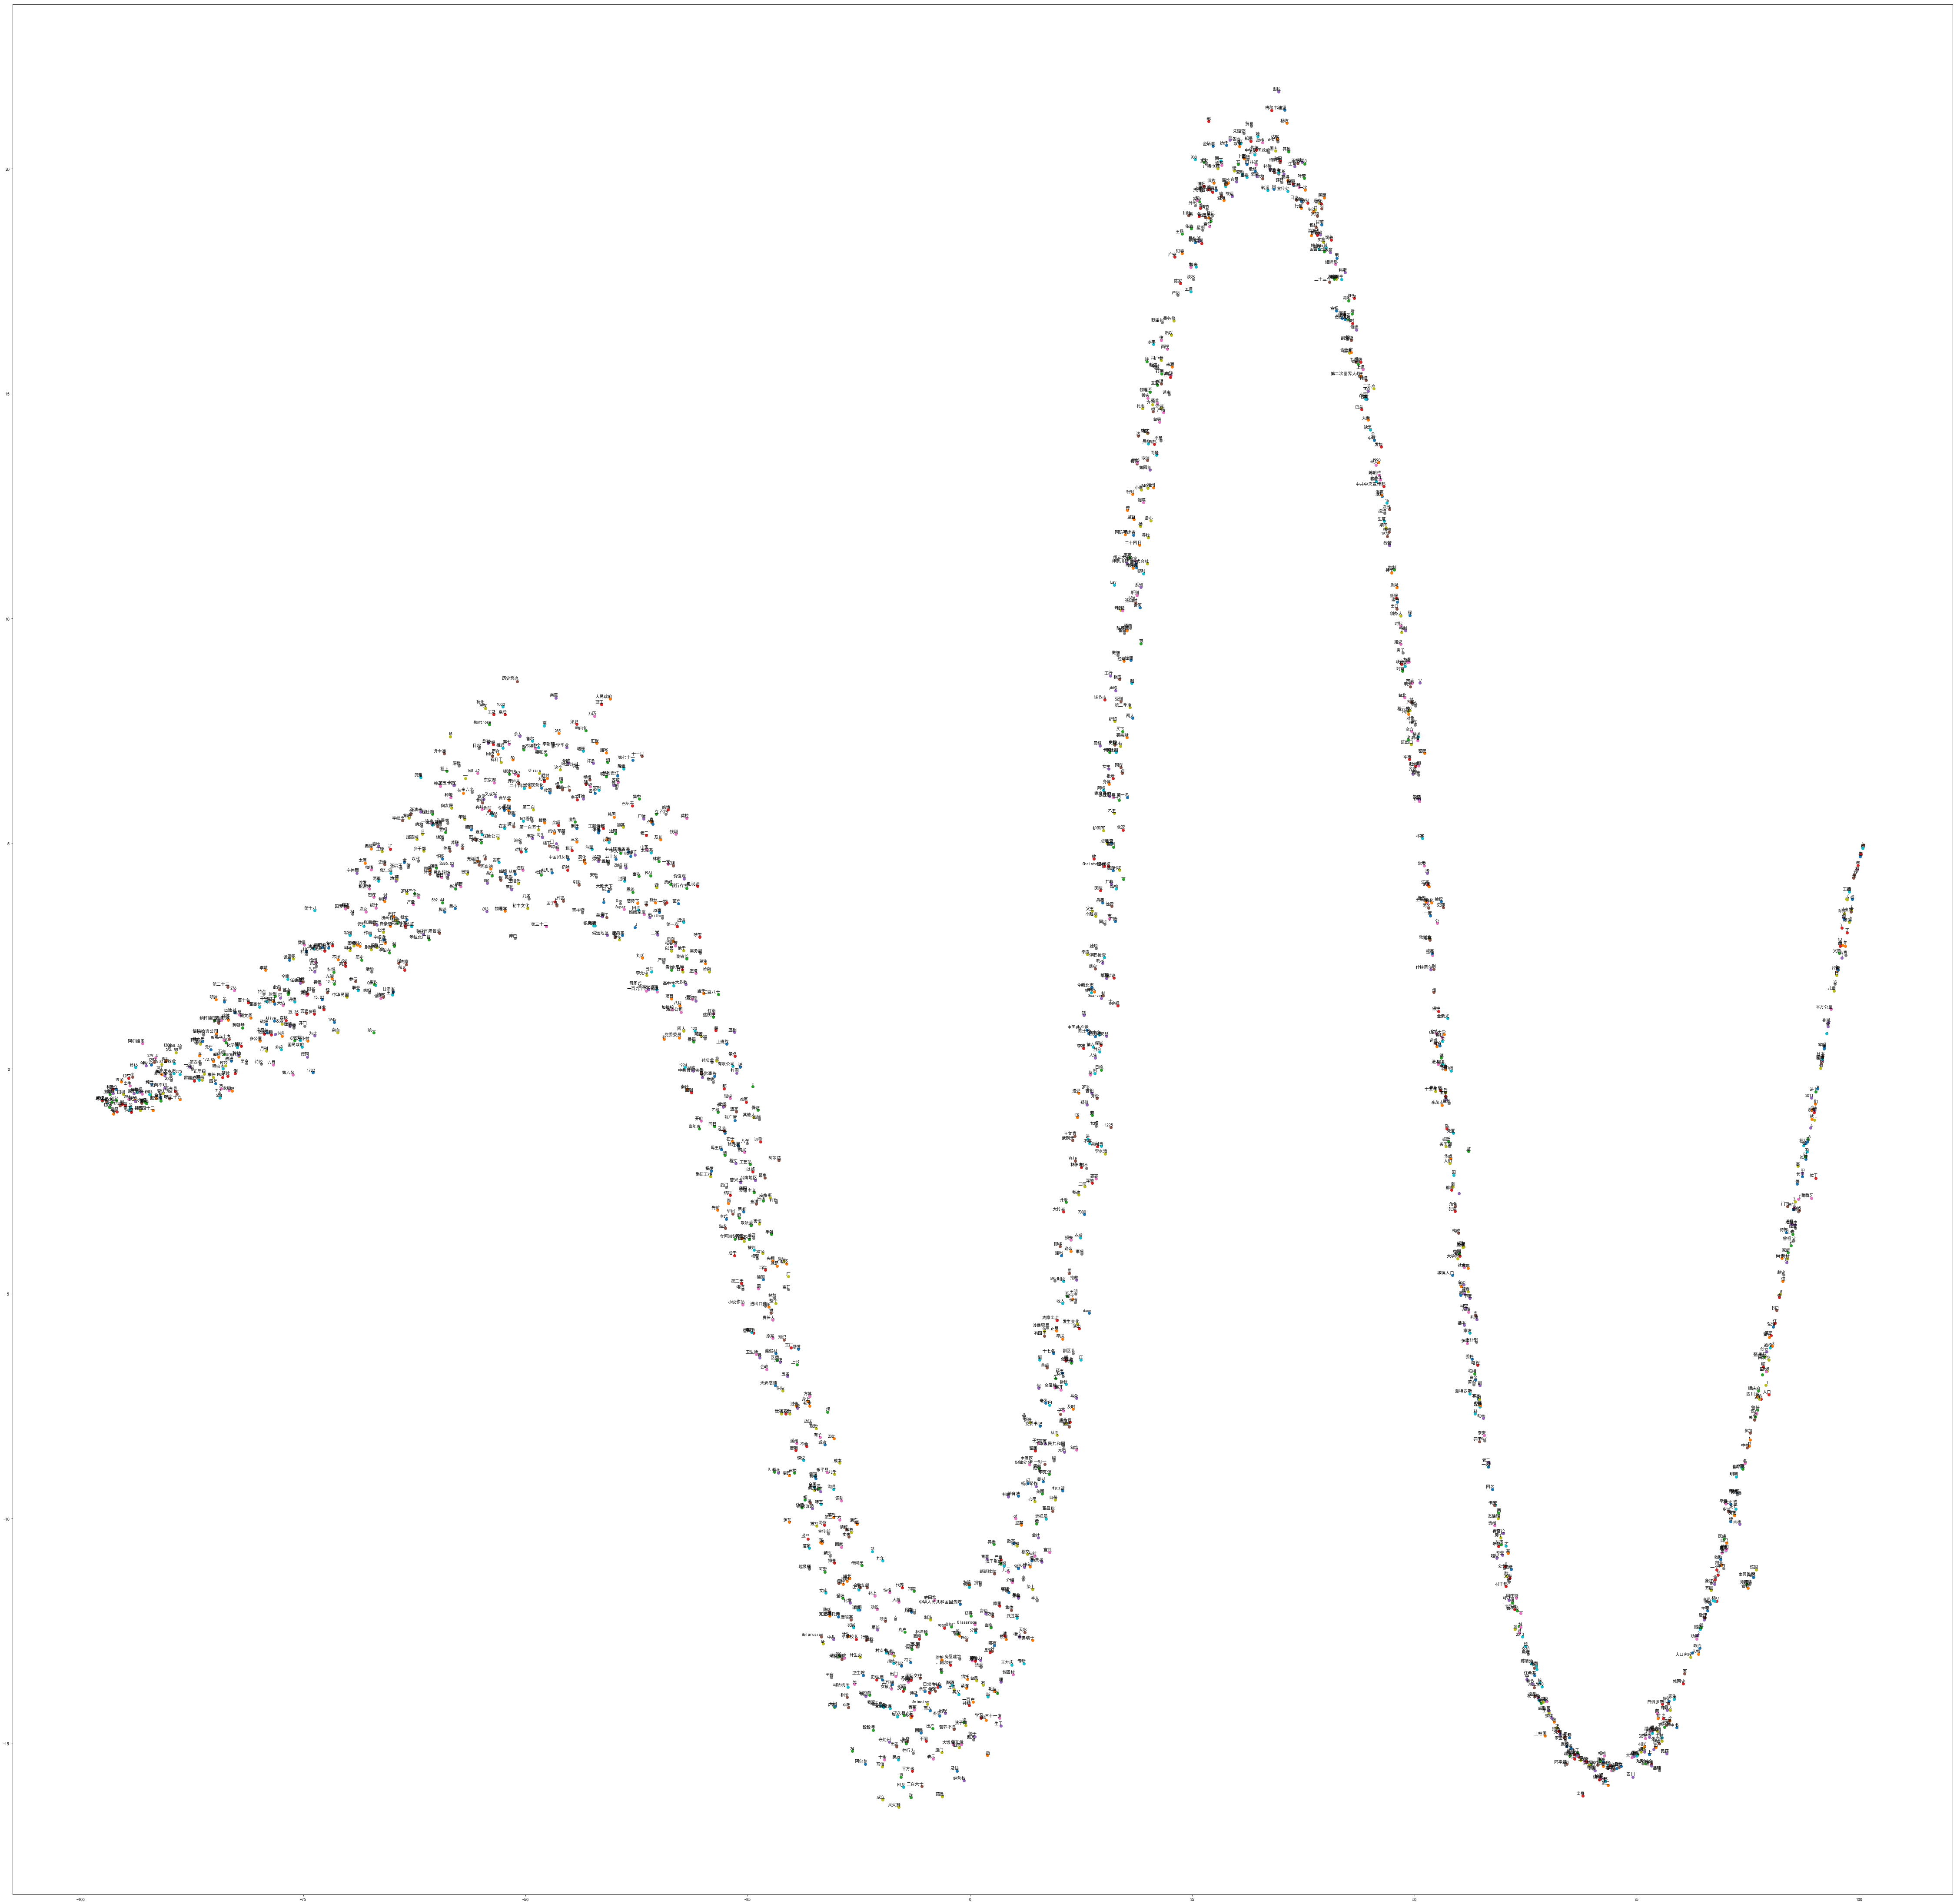

In [21]:
#只使用部分的TOKEN, 500行，否则时间太长了
#中文字符不显示问题：http://www.pythoner.com/200.html

import os,jieba
from gensim.models.word2vec import  LineSentence
from gensim.test.utils import  get_tmpfile
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt



def get_token():
    with open('zh_wiki_01', 'r', encoding='utf-8') as f:
        all_text = f.readlines()
        #print(all_text)
        ct = 0
        each_TOKEN = []
        for line in all_text:
            if ct == 500: break
            if (ct % 100 == 0) or (ct == len(all_text) - 1):
                print('save_each_TOKEN :{}'.format(ct))
                TOKEN.append(each_TOKEN)
                each_TOKEN = []
            line = line.strip('\n')
            each_TOKEN += jieba.lcut(line)
            ct += 1


    with open(token_txt_file, 'a+', encoding='utf-8') as f:
        for each in TOKEN:
            write_something = ''
            write_something += ' '.join(each)
            f.write(write_something)

            
def save_token():
    cur_path = os.path.abspath('.')
    sentences = LineSentence(os.path.join(cur_path, token_txt_file))
    path = get_tmpfile(modle_file)
    model = Word2Vec(sentences, min_count = 1, workers = 4)
    model.save(modle_file)



def tsne_plot():
    model = Word2Vec.load(modle_file)
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)

    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=(80, 80))
    for i in range(len(x)):
        plt.scatter(x[i], y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()
            
if __name__ == '__main__':
    TOKEN = []
    token_txt_file = 'token_500.txt'
    modle_file = "500.model"
    
    
    get_token()
    save_token()
    
    tsne_plot()
    











